# Missing Value and Outlier Analysis

**Contents:**
- [Importing Data](#Importing-Data)
- [Missing Value Analysis](#Missing-Value-Analysis)
- [Outlier Analysis](#Outlier-Analysis)
- [Imputation](#Imputation)
- [Golden Dataset](#Golden-Dataset)

## Importing Data

In [1]:
# Import necessary modules
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import seaborn as sns

# Display 100 columns max
pd.set_option('display.max_columns', 100)

# Display 20 characters max within a cell
# pd.set_option('max_colwidth',60)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_pickle("scout_for_missing_and_outliers.pkl")

In [3]:
df.shape

(15919, 128)

## Missing Value Analysis

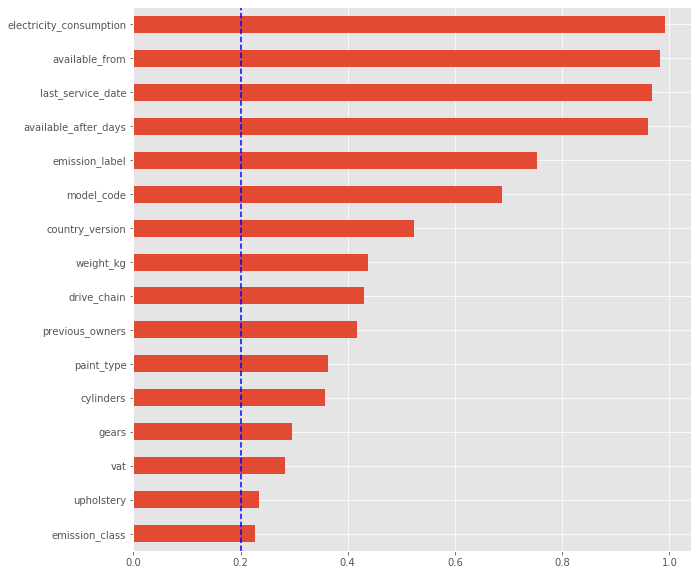

In [4]:
# Percentage of missing values withing columns (new dataset with missing values > 0)
ax = df.isnull().mean()[df.isnull().mean() > 0.2].sort_values().plot.barh(figsize=(10,10))
ax.axvline(x=0.2, color='b', linestyle='--')

In [5]:
# columns_to_keep = ['emission_class', 'consumption', 'nr.of seats']

For the **Fraud Detection** process, we may need to investigate 
 - Missing at Random (MAR): Missing at random means that the propensity for a data point to be missing is not related to the missing data, but it is related to some of the observed data
 - Missing Completely at Random (MCAR): The fact that a certain value is missing has nothing to do with its hypothetical value and with the values of other variables.
 - Missing not at Random (MNAR): Two possible reasons are that the missing value depends on the hypothetical value (e.g. People with high salaries generally do not want to reveal their incomes in surveys) or missing value is dependent on some other variable’s value (e.g. Let’s assume that females generally don’t want to reveal their ages! Here the missing value in age variable is impacted by gender variable).

For the current impementation of predicting the `price`, we'll drop some of the columns which have high amount of missings.

However, it is worth noting that, in the first two cases, it is safe to remove the data with missing values depending upon their occurrences, while in the third case removing observations with missing values can produce a bias in the model. So we have to be really careful before removing observations.

In [6]:
# Create a new DataFrame with columns < 0.2 missing
df = df.loc[:, df.isnull().mean() < 0.2]
df.shape

(15919, 112)

In [7]:
# Select non-dummy columns
non_dummy = df.loc[:, ~df.columns.str.contains('ss_|cc_|^ext_|ent_', regex=True)]
non_dummy.shape

(15919, 18)

In [8]:
# Number of rows with more than half missing
(non_dummy.isna().sum(axis=1) > non_dummy.shape[1]/2).sum()

0

In [9]:
# Ratio and number of the missing values for non-dummy columns
pd.DataFrame({"Ratio" : non_dummy.isna().mean().sort_values(ascending=False), 
             "Number": non_dummy.isna().sum().sort_values(ascending=False)})

,Ratio,Number
consumption_comb,0.181104,2883
co2_emission,0.153025,2436
age,0.100320,1597
km,0.064326,1024
nr_of_seats,0.061373,977
body_color,0.037502,597
displacement,0.031158,496
nr_of_doors,0.013317,212
hp,0.005528,88
body,0.003769,60


The most significant factors are (initial modeling results):
 - Model > no missing
 - Make > no missing
 - Type > almost no missing
 - Age > many missing *****
 - Gearing type (manuel, automatic, semi-automatic) > no missing
 - cc_, ss_, ent_, ext_  > many missing
 - Body > almost no missing
 - hp > almost no missing
 - Nr.of Doors > almost no missing
 - km > almost no missing
 
????Normalize ettigimiz icin yukaridaki degerleri, significance level (feature importance level) olarak da alabilir miyiz?

In [10]:
# Select dummy columns
dummy = df.loc[:, df.columns.str.contains('ss_|cc_|^ext_|ent_', regex=True)]
# Ratio of the missing values for non-dummy columns
dummy.isna().mean().unique()

array([0.06168729, 0.08631195, 0.05779257, 0.18606696])

Ideas:
----
- `Make` and `model` have no missing values. This might be because of the web scraping algorithm, since we used `make` and `model` as parameters in the scraping process. (it might be worth trying not specifying `make` and `model` in the scraping process and see what we'll get)
- `Make` and `model` can be used to fill missing values for many columns. Using `.groupby()` is a good  option. One of the following strategies can be chosen.
    + Mean
    + Median
    + Mode (Most frequent)
- It is not possible to use `make` and `model` to fill every column. We'll investigate correlations to develop a better strategy to impute missing values for the following columns:
    + `Age`
    + `Km`

Text(0.5, 1, 'Correlation Heatmap of Non-Dummy Variables')

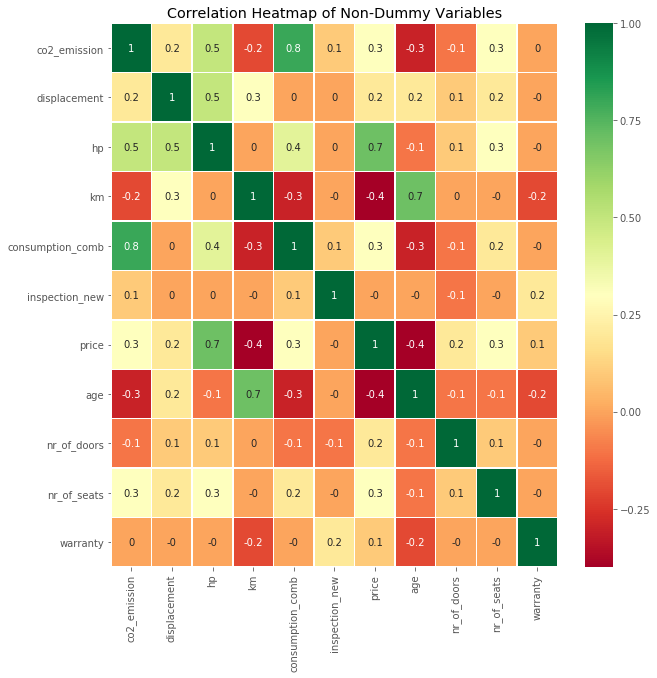

In [11]:
# Add figure size
plt.figure(figsize=(10,10))

# Plot heatmap of correlations
ax = sns.heatmap(non_dummy.corr().round(1), linewidths=.5, cmap="RdYlGn", annot=True)
ax.set_title('Correlation Heatmap of Non-Dummy Variables')

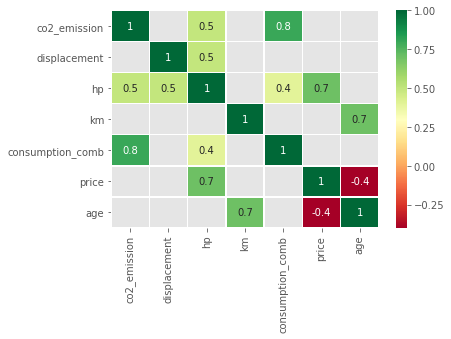

In [12]:
# Create a correlation DataFrame
corr = non_dummy.corr()

# Which columns are correlated
cols = ((corr.abs() > 0.4) & (corr.abs() < 1)).sum() > 0

# Plot the new correlation matrix
ax = sns.heatmap(corr.loc[cols,cols][corr.loc[cols,cols].abs() > 0.4].round(1), linewidths=.5, cmap="RdYlGn", annot=True)

Ideas: 
---
- We can use `km` to fill `age`, since there are more missings in the `age` column. We can also use `age` to fill `km` if the missings do not match.
- We can use `co2_emission` and `hp` to fill `consumption_comb`, and vice versa.
- We may drop `consumption_comb` since it is highly correlated and there are almost %20 missing. But first, we may use it to fill `co2_emission`.
- `hp` has correlation with many columns. 
- Regression to fill might be another option.

## Outlier Analysis

In [13]:
# Select numeric columns (without dummies)
df_numeric = non_dummy.select_dtypes('number')
df_numeric.describe()

,co2_emission,displacement,hp,km,consumption_comb,inspection_new,price,age,nr_of_doors,nr_of_seats,warranty
count,13483.000000,15423.000000,15831.000000,14895.000000,13036.000000,15919.000000,15919.000000,14322.000000,15707.000000,14942.000000,15919.000000
mean,117.953942,1423.540881,88.367696,34130.127828,4.784527,0.224260,18019.896727,1.542382,4.656077,4.949873,0.659526
std,20.245589,333.530658,26.835135,37352.977568,0.919294,0.417107,7386.169409,1.076917,0.645298,0.489872,0.473883
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,13.000000,0.000000,1.000000,2.000000,0.000000
25%,104.000000,1229.000000,66.000000,5153.000000,4.000000,0.000000,12850.000000,1.000000,4.000000,5.000000,0.000000
50%,116.000000,1461.000000,85.000000,22740.000000,4.700000,0.000000,16900.000000,1.000000,5.000000,5.000000,1.000000
75%,129.000000,1598.000000,101.000000,49371.500000,5.400000,0.000000,21900.000000,3.000000,5.000000,5.000000,1.000000
max,990.000000,16000.000000,294.000000,317000.000000,9.100000,1.000000,74600.000000,3.000000,7.000000,7.000000,1.000000


In [14]:
df.describe(exclude='number')

,make,model,body,body_color,gearing_type,fuel,type
count,15919,15919,15859,15322,15919,15913,15917
unique,3,9,9,14,3,4,5
top,Opel,A3,Sedans,Black,Manual,gasoline,Used
freq,7343,3097,7903,3745,8153,8545,11096


In [15]:
# Create a list of columns for outlier analysis
column_list = ["co2_emission", "displacement", "hp", "consumption_comb"]

# Print min and max values
pd.DataFrame({'min':df[column_list].min(), 'max':df[column_list].max()})

,min,max
co2_emission,0.0,990.0
displacement,1.0,16000.0
hp,1.0,294.0
consumption_comb,0.0,9.1


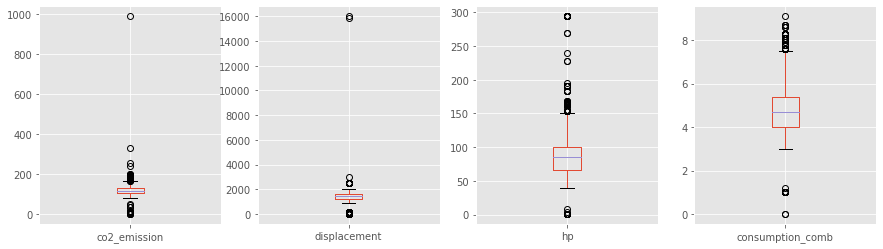

In [16]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

# Plot subplots
i = 0
for column in column_list:
    # Plot boxplot[i]
    df[column].plot.box(ax = ax[i])
    
    # Next subplot
    i += 1

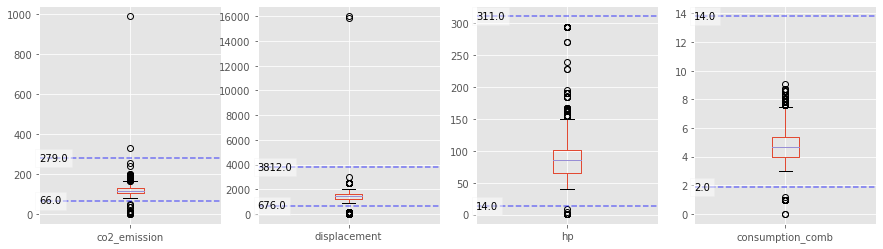

In [17]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

# Plot subplots
i = 0
for column in column_list:
    # Plot boxplot[i]
    df[column].plot.box(ax = ax[i])
    
    # Create limits for outlier detection
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    y_limit_high = Q3 + IQR * 6
    y_limit_low = Q1 - IQR * 1.5
    
    # Draw horizontal lines for limits
    ax[i].axhline(y=y_limit_high, color='b', linestyle='--', alpha = 0.5)
    ax[i].text(0, y_limit_high, y_limit_high.round(), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ax[i].get_yaxis_transform())
    ax[i].axhline(y=y_limit_low, color='b', linestyle='--', alpha = 0.5)
    ax[i].text(0, y_limit_low, y_limit_low.round(), va='center', ha="left", bbox=dict(facecolor="w",alpha=0.5),
        transform=ax[i].get_yaxis_transform())
    
    # Next subplot
    i += 1

In [18]:
def detect_replace_outliers(data, columns, thres_low, thres_high):
    '''
    Detects outliers and replace them with NaN in a conservative way to
    prepare data for modeling. Specific threshold or limit for each
    feature can be used for better results. This function needs to be
    revisited for further analyis! 
    '''
    data_new = data[columns].copy()
    Q1 = data_new.quantile(0.25)
    Q3 = data_new.quantile(0.75)
    IQR = Q3 - Q1
    
    limit_low = thres_low * IQR
    limit_high = thres_high * IQR
    
    # Print number of outliers by column
    print(((data_new < Q1 - limit_low) | (data_new > Q3 + limit_high)).sum())
    
#     # Print number of rows affected
#     print("\nNumber of rows affected:", 
#           (((data_new < Q1 - limit_low) | (data_new > Q3 + limit_high)).sum(axis=1) > 0 ).sum()
#          ) 
        
    return data_new[(data_new > Q1 - limit_low) & (data_new < Q3 + limit_high)]

#detect_replace_outliers(df, column_list, 1.5, 6);

In [19]:
df[column_list] = detect_replace_outliers(df, column_list, 1.5, 6)

co2_emission        21
displacement        53
hp                  22
consumption_comb    40
dtype: int64


In [20]:
# Check to see whether the function is working
pd.DataFrame({'min':df[column_list].min(), 'max':df[column_list].max()})

,min,max
co2_emission,80.0,253.0
displacement,890.0,2967.0
hp,40.0,294.0
consumption_comb,3.0,9.1


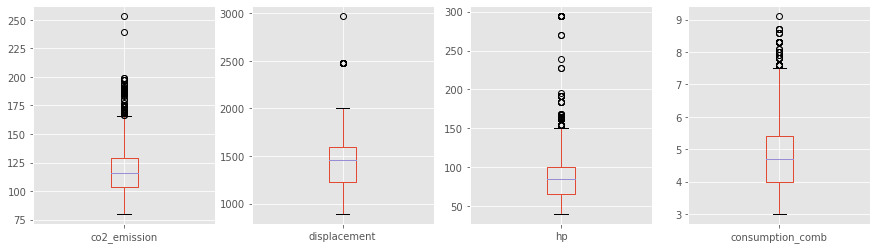

In [21]:
# Create subplots
fig, ax = plt.subplots(1, 4, figsize=(15, 4))

# Plot boxplots for the new values of specified columns
i = 0
for column in column_list:
    df[column].plot.box(ax = ax[i])
    i += 1

## Price (Target Variable)

It is better to pay special attention to the target variable. If something is wrong with the Price of an ad, we may need to drop that row.

In [22]:
df.price.describe()

count    15919.000000
mean     18019.896727
std       7386.169409
min         13.000000
25%      12850.000000
50%      16900.000000
75%      21900.000000
max      74600.000000
Name: price, dtype: float64

The **min** value of the `price` appears to be wrong.

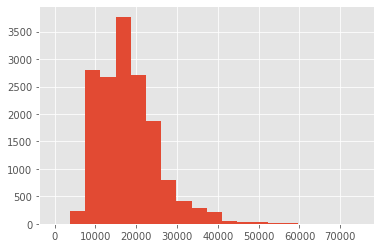

In [23]:
df.price.hist(bins=20)

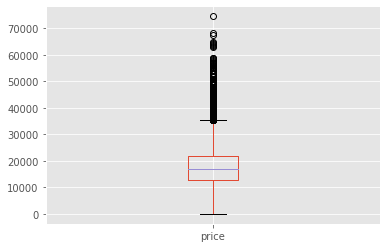

In [24]:
df.price.plot.box()

In [25]:
df.price.sort_values().head()
# There are 4 wrong entries

8594      13
8828     120
6066     255
8829     331
8827    4950
Name: price, dtype: int64

In [26]:
# Drop 4 rows from df
df.drop(df.price.sort_values().head(4).index.to_list(), inplace=True)

## Imputation

In [29]:
# Select non-dummy columns
non_dummy = df.loc[:, ~df.columns.str.contains('ss_|cc_|^ext_|ent_', regex=True)]

# Ratio and number of the missing values for non-dummy columns
missing_df = pd.DataFrame({"Ratio" : non_dummy.isna().mean().sort_values(ascending=False), 
 "Nr. of Missing": non_dummy.isna().sum().sort_values(ascending=False)})
missing_df

,Ratio,Nr. of Missing
consumption_comb,0.183600,2922
co2_emission,0.154320,2456
age,0.100346,1597
km,0.064342,1024
nr_of_seats,0.061389,977
body_color,0.037512,597
displacement,0.034496,549
nr_of_doors,0.013321,212
hp,0.006912,110
body,0.003770,60


In [30]:
# Select dummy columns
dummy = df.loc[:, df.columns.str.contains('ss_|cc_|^ext_|ent_', regex=True)]
# Ratio of the missing values for non-dummy columns
dummy.isna().mean().value_counts()

0.057807    38
0.061703    29
0.186114    17
0.086334    10
dtype: int64

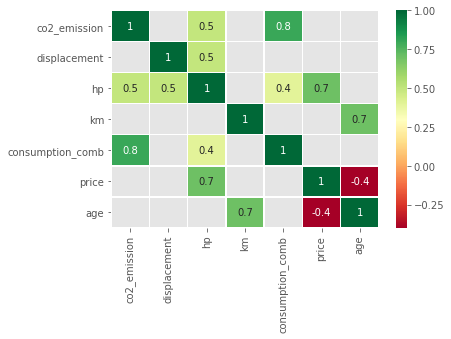

In [31]:
# Plot the new correlation matrix
ax = sns.heatmap(corr.loc[cols,cols][corr.loc[cols,cols].abs() > 0.4].round(1), linewidths=.5, cmap="RdYlGn", annot=True)

In [32]:
import pandas_profiling
non_dummy.profile_report(notebook={'iframe':{'height':'500px'}})

# profile = non_dummy.profile_report(title='Pandas Profiling Report')
# profile.to_file(output_file="output_non_dummy.html")

### Imputation Strategies

Columns|Methods|Note
:------|:------|----
consumption_comb|-|Will be dropped after filling co2_emission
co2_emission|Regression or mean|make, model + consumption_comb columns can be used
age|mode, median or Classification|make, model + km column can be used
km|median, mean or Regression|make, model + age column can be used. Highly skewed > median
nr_of_seats|mode|make, model + body columns can be used. (May have relationship with body)
body_color|mode|make, model columns can be used
displacement|mode, median or Classification/Regression|hp column can also be used
nr_of_doors|mode|make, model + body columns can also be used. (May have relationship with body)
hp|mode or Regression/Classification|make, model + displacement and co2_emission columns can be used
body|mode|make, model + nr_of_doors columns can be used
fuel|mode|make, model columns can be used
type|mode|Groupby may not be necessary.

Methods:

- Impute using **Statistics** (Simple imputation)
    - Mean
      - Suitable for continuous data **without** outliers
    - Median
      - Suitable for continuous data with outliers
    - Mode (most common/frequent value)
      - Suitable for both categorical and numerical variables

- Impute with some **Constant** value (outside fixed value range -999,-1 etc) (Also a part of simple imputation)
    - This method is useful as it gives the possibility to group missing values as a separate category represented by a constant value. It is a preferred option when it doesn’t make sense to try and predict a missing value. The downside is that performance of linear models can suffer.Use a global constant to fill in for missing values.

- Regression (Iterative Regression) or Classification

- Backfill, Forwardfill
    - Suitable for time-series
    - Last Observation Carried Forward (LOCF) & Next Observation Carried Backward (NOCB)

- Interpolation, Extrapolation
    - Suitable for time-series

- Multiple Imputation**
    - This is one of the most preferred method for imputation for the following reasons:
        - Easy to use
        - No biases (if imputation model is correct)

- KNN (K Nearest Neighbors)

- Random Forest

Note: Replacing with mean, median, mode value: This simple imputation method is based on treating every variable individually, ignoring any interrelationships with other variables.This method is beneficial for simple linear models and NN. But for **tree based methods** it can be harder for the algorithm to understand that there was a missing value. Please note that Mean, Median and Mode imputation diminishes any correlations involving the variable(s) that are imputed. This is because we assume that there is no relationship between the imputed variable and any other measured variables. Thus, those imputations have some attractive properties for univariate analysis but become problematic for multivariate analysis.

Note: In the statistics community, it is common practice to perform multiple imputations, generating, for example, m separate imputations for a single feature matrix. Each of these m imputations is then put through the subsequent analysis pipeline (e.g. feature engineering, clustering, regression, classification). The m final analysis results (e.g. held-out validation errors) allow the data scientist to obtain understanding of how analytic results may differ as a consequence of the inherent uncertainty caused by the missing values. The above practice is called multiple imputation.

Note: sklearn `MissingIndicator` transformer is useful to transform a dataset into corresponding binary matrix indicating the presence of missing values in the dataset. This transformation is useful in conjunction with imputation. When using imputation, preserving the information about which values had been missing can be informative.


The graph below is from another [source](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4). I think that this graph is lacking some information and it is not 100% correct. However, it gives a perspective. Thus, I found it useful.
![Imputation](https://miro.medium.com/max/1400/1*_RA3mCS30Pr0vUxbp25Yxw.png)


### Simple Imputation Using `make` and `model` for Grouping

In [33]:
non_dummy.groupby(['make', 'model']).first()

co2_emission  displacement     hp        km  \
make    model                                                   
Audi    A1                99.0        1422.0   66.0   56013.0   
        A2                 NaN        1598.0   85.0   26166.0   
        A3               116.0        1498.0  110.0   19800.0   
Opel    Astra            119.0        1598.0  100.0  260000.0   
        Corsa            110.0        1398.0   66.0  100000.0   
        Insignia         129.0        1598.0  100.0  174564.0   
Renault Clio              92.0        1461.0   66.0  161556.0   
        Duster           150.0        1998.0   77.0     101.0   
        Espace           120.0        1598.0  118.0  141000.0   

                  consumption_comb           body body_color gearing_type  \
make    model                                                               
Audi    A1                     3.8         Sedans      Black    Automatic   
        A2                     4.9       Off-Road       Grey       Manual   
        A3                     5.1    Convertible        Red    Automatic   
Opel    Astra                  4.5  Station wagon     Silver    Automatic   
        Corsa                  4.7         Sedans     Silver    Automatic   
        Insignia               4.9  Station wagon       Blue    Automatic   
Renault Clio                   3.5        Compact      White    Automatic   
        Duster                 NaN       Off-Road      Black    Automatic   
        Espace                 4.6  Station wagon      White    Automatic   

                  inspection_new  price  age      fuel  nr_of_doors  \
make    model                                                         
Audi    A1                     1  15770  3.0    diesel          5.0   
        A2                     0  28200  1.0    diesel          5.0   
        A3                     0  10893  1.0  gasoline          2.0   
Opel    Astra                  0   6000  3.0    diesel          5.0   
        Corsa                  0   7700  3.0  gasoline          5.0   
        Insignia               0   8980  3.0    diesel          4.0   
Renault Clio                   0   7650  3.0    diesel          4.0   
        Duster                 0  13250  0.0  gasoline          5.0   
        Espace                 0  17500  3.0    diesel          5.0   

                  nr_of_seats            type  warranty  
make    model                                            
Audi    A1                5.0            Used         1  
        A2                5.0  Employee's car         1  
        A3                4.0            Used         1  
Opel    Astra             5.0            Used         0  
        Corsa             5.0            Used         1  
        Insignia          5.0            Used         0  
Renault Clio              5.0            Used         0  
        Duster            5.0             New         1  
        Espace            5.0            Used         0

#### Mode

##### body, body_color, fuel, type

In [34]:
# Columns to apply Simple Imputation: MODE
cols_impute_mode = ['body_color', 'fuel', 'type', 'body']

'''
It may be better to fill body using both 'model' and 'nr_or_doors';
however, there are many missing values in 'nr_of_doors' column!
Filling 'body' with random (normal) values might have been a better choice
Should be consideref for further analysis!!
'''

df[cols_impute_mode].isna().sum()

body_color    597
fuel            6
type            2
body           60
dtype: int64

In [35]:
df[cols_impute_mode].describe()

,body_color,fuel,type,body
count,15318,15909,15913,15855
unique,13,4,5,9
top,Black,gasoline,Used,Sedans
freq,3745,8542,11094,7902


In [36]:
# Fill missing values
df[cols_impute_mode] = df.groupby('model')[cols_impute_mode].transform(lambda x: x.fillna(x.mode()[0]))

In [37]:
# Check to see if there are no NaNs
df[cols_impute_mode].isna().sum()

body_color    0
fuel          0
type          0
body          0
dtype: int64

In [38]:
# Check to see if the imputations implemented correctly
df[cols_impute_mode].describe()

,body_color,fuel,type,body
count,15915,15915,15915,15915
unique,13,4,5,9
top,Black,gasoline,Used,Sedans
freq,3957,8545,11096,7924


##### nr_of_doors, nr_of_seats

In [39]:
# Columns to apply Simple Imputation: MODE
cols_impute_mode = ['nr_of_doors', 'nr_of_seats']

df[cols_impute_mode].isna().sum()

nr_of_doors    212
nr_of_seats    977
dtype: int64

In [40]:
# Fill missing values
df[cols_impute_mode] = df.groupby(['body'])[cols_impute_mode].transform(lambda x: x.fillna(x.mode()[0]))
'''
Grouping by multiple columns to fill the missing values gave an error. For now, I used 
only 'body' column to fill in the nr_of_doors/seats columns. My intention was, however, to 
group by both 'model' and 'body'
'''

"\nGrouping by multiple columns to fill the missing values gave an error. For now, I used \nonly 'body' column to fill in the nr_of_doors/seats columns. My intention was, however, to \ngroup by both 'model' and 'body'\n"

In [41]:
df[cols_impute_mode].isna().sum()

nr_of_doors    0
nr_of_seats    0
dtype: int64

#### Mean

In [42]:
# Columns to use Simple Imputation: MEAN
cols_impute_mean = []

#### Median

In [43]:
# Columns to use Simple Imputation: MEAN
cols_impute_median = []

### Create a Clean DataFrame

In [44]:
# Prepare data for modeling
drop_list = ['consumption_comb']

# Save the golden dataset to pickle for modeling (with missing values)
pd.get_dummies(df.drop(drop_list, axis=1)).to_pickle('autos_missing_golden_20190719.pkl')

# Drop unnecessary columns
df_clean = df.drop(drop_list, axis=1)

# Create a new DataFrame w/o missing values
df_clean = pd.get_dummies(df_clean).dropna()

# Save the golden dataset to pickle for modeling
df_clean.to_pickle('autos_clean_golden_20190719.pkl')

### Other Imputation Methods

Remaining columns: ~consumption_comb~, co2_emission, age, km, displacement, hp

In [46]:
# Select non-dummy columns
non_dummy = df.loc[:, ~df.columns.str.contains('ss_|cc_|^ext_|ent_', regex=True)]

# Show # missing values
non_dummy.isna().sum().sort_values(ascending=False)

consumption_comb    2922
co2_emission        2456
age                 1597
km                  1024
displacement         549
hp                   110
body                   0
make                   0
model                  0
warranty               0
type                   0
gearing_type           0
inspection_new         0
price                  0
fuel                   0
nr_of_doors            0
nr_of_seats            0
body_color             0
dtype: int64

#### Regression

Linear Regression for `hp` and `displacement` columns. 

In [47]:
df.hp.describe()

count    15805.000000
mean        88.492123
std         26.658610
min         40.000000
25%         66.000000
50%         85.000000
75%        101.000000
max        294.000000
Name: hp, dtype: float64

In [48]:
df.hp.nunique()

77

In [49]:
df.hp.shape, df['hp'].notnull().sum()

((15915,), 15805)

In [50]:
def model_to_fillna(data, column_to_fill, regressor):
    # Drop missing values
    df_model = data.dropna().copy()
    X = pd.get_dummies(df_model.drop(column_to_fill, axis=1).drop('price', axis=1))
    y = df_model[column_to_fill].copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=57)
    # Fit the regressor to the training data
    regressor.fit(X_train, y_train)
    
    # Print the R-squared (or score)
    print("R^2 (or score): {0:.2f}".format(regressor.score(X_test, y_test)))
    
    return regressor, X.columns.values

In [51]:
model, col_names = model_to_fillna(df, 'hp', LinearRegression())

R^2 (or score): 0.87


In [56]:
model, col_names = model_to_fillna(df, 'hp', RandomForestRegressor(random_state=0, n_estimators=100))

R^2 (or score): 0.99


In [57]:
pd.DataFrame({'feature': col_names, 'importance':model.feature_importances_}).sort_values('importance', ascending=False).head(10)

,feature,importance
1,displacement,0.643791
32,consumption_comb,0.100502
108,model_Astra,0.052663
139,fuel_gasoline,0.036085
0,co2_emission,0.035970
138,fuel_diesel,0.035372
107,model_A3,0.015195
110,model_Corsa,0.010853
112,model_Insignia,0.010275
34,age,0.007104


In [58]:
#pd.get_dummies(df)[df.hp.isna()].drop(['price', 'hp'], axis=1)

In [60]:
# # Create the regressor
# reg = LinearRegression()

# # Fit the regressor to the training data
# reg.fit(X_train, y_train)

# # Print the R-squared
# print("R^2: {0:.2f}".format(reg.score(X_test, y_test)))

In [61]:
# reg_rf = RandomForestRegressor(random_state=0, n_estimators=100)

# reg_rf.fit(X_train, y_train)

# reg_rf.score(X_test, y_test)

# #pd.DataFrame({'x':X_hp.columns.values, 'y':reg_rf.feature_importances_})

In [62]:
# # Plotting Decision Tree

# from sklearn.tree import export_graphviz
# # Export as dot file
# export_graphviz(reg_rf.estimators_[5], out_file='tree.dot', 
#                 feature_names = X_hp.columns.values,
#                 class_names = y_hp.name,
#                 rounded = True, proportion = False, 
#                 precision = 2, filled = True)

# # Convert to png using system command (requires Graphviz)
# !dot -Tpng tree.dot -o tree.png -Gdpi=600

# # Display in jupyter notebook
# # from IPython.display import Image
# # Image(filename = 'tree.png')

#### Classification

#### IterativeImputer

In [63]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
'''
Multivariate imputer that estimates each feature from all the others.
Note:This estimator is still experimental for now
'''
imp = IterativeImputer(initial_strategy='most_frequent',
                 max_iter=5, n_nearest_features=None,
                 random_state=0)

df_new = imp.fit_transform(pd.get_dummies(df.drop('price', axis=1)))

/anaconda3/lib/python3.7/site-packages/sklearn/impute/_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [64]:
len(pd.get_dummies(df.drop('price', axis=1)).columns.values)

150

In [65]:
df_golden = pd.DataFrame(df_new)
df_golden.columns = pd.get_dummies(df.drop('price', axis=1)).columns.values
df_golden = df_golden.join(df.price).dropna()
df_golden.head()

,co2_emission,displacement,hp,km,ss_abs,ss_adaptive_cruise_control,ss_adaptive_headlights,ss_alarm_system,ss_blind_spot_monitor,ss_central_door_lock,ss_central_door_lock_with_remote_control,ss_daytime_running_lights,ss_driver_drowsiness_detection,ss_driver_side_airbag,ss_electronic_stability_control,ss_emergency_brake_assistant,ss_emergency_system,ss_fog_lights,ss_head_airbag,ss_immobilizer,ss_isofix,ss_led_daytime_running_lights,ss_led_headlights,ss_lane_departure_warning_system,ss_night_view_assist,ss_passenger_side_airbag,ss_power_steering,ss_rear_airbag,ss_side_airbag,ss_tire_pressure_monitoring_system,ss_traction_control,ss_traffic_sign_recognition,ss_xenon_headlights,consumption_comb,inspection_new,age,ent_media_bluetooth,ent_media_cd_player,ent_media_digital_radio,ent_media_hands_free_equipment,ent_media_mp3,ent_media_on_board_computer,ent_media_radio,ent_media_sound_system,ent_media_television,ent_media_usb,nr_of_doors,nr_of_seats,warranty,cc_air_conditioning,...,ext_tuned_car,ext_voice_control,ext_winter_tyres,make_Audi,make_Opel,make_Renault,model_A1,model_A2,model_A3,model_Astra,model_Clio,model_Corsa,model_Duster,model_Espace,model_Insignia,body_Compact,body_Convertible,body_Coupe,body_Off-Road,body_Other,body_Sedans,body_Station wagon,body_Transporter,body_Van,body_color_Beige,body_color_Black,body_color_Blue,body_color_Bronze,body_color_Brown,body_color_Green,body_color_Grey,body_color_Orange,body_color_Red,body_color_Silver,body_color_Violet,body_color_White,body_color_Yellow,gearing_type_Automatic,gearing_type_Manual,gearing_type_Semi-automatic,fuel_diesel,fuel_electric,fuel_gasoline,fuel_lpg,type_Demonstration,type_Employee's car,type_New,type_Pre-registered,type_Used,price
0,99.0,1422.0,66.0,56013.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,3.8,1.0,3.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,5.0,5.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,15770.0
1,129.0,1798.0,141.0,80000.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,5.6,0.0,2.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,4.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,14500.0
2,99.0,1598.0,85.0,83450.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,3.8,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,4.0,4.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14640.0
3,99.0,1422.0,66.0,73000.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,3.8,0.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,3.0,4.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,14500.0
4,109.0,1422.0,66.0,16200.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,4.1,1.0,3.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,5.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,16790.0


In [66]:
df_golden.isna().sum().sum()

0

In [67]:
df_golden.shape

(15911, 151)

In [68]:
pd.DataFrame({'golden': df_golden.mean(), 'df':pd.get_dummies(df.drop('price', axis=1)).mean()})

,golden,df
age,1.406478,1.542674
body_Compact,0.198102,0.198178
body_Convertible,0.000503,0.000503
body_Coupe,0.001571,0.001571
body_Off-Road,0.003520,0.003519
body_Other,0.018164,0.018159
body_Sedans,0.497957,0.497895
body_Station wagon,0.223807,0.223814
body_Transporter,0.005531,0.005529
body_Van,0.050845,0.050833


### co2_emission, consumption_comb

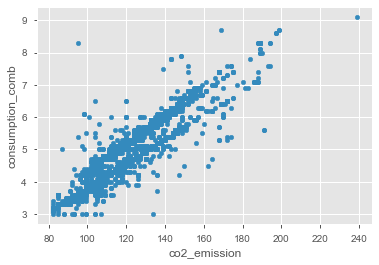

In [69]:
df.plot.scatter('co2_emission', 'consumption_comb')

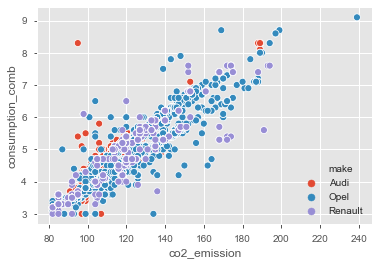

In [70]:
sns.scatterplot('co2_emission', 'consumption_comb', data=df, hue='make')

In [71]:
# Ratios of missing values
df.co2_emission.isna().mean(), df.consumption_comb.isna().mean()

(0.15431982406534717, 0.18360037700282753)

In [72]:
# Ratios of missings in both columns
(df.co2_emission.isna() & df.consumption_comb.isna()).mean()

0.12076657241595978

In [73]:
# Ratio of co2_emission missing, but consumption_comb is not missing
(df.co2_emission.isna() & df.consumption_comb.notnull()).mean()

0.03355325164938737

## Golden Dataset

In [74]:
# Prepare data for modeling

drop_list = ['consumption_comb']

# Drop unnecessary columns
df.drop(drop_list, axis=1, inplace=True)

# Save the golden dataset to pickle for modeling
df_golden.to_pickle('autos_golden_20190719.pkl')